In [56]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import quantstats as qs
from yahoo_fin import stock_info as si
from scipy.stats import norm
import numpy as np


In [57]:
from yahoo_fin import stock_info as si

spx = si.get_data('^GSPC')['adjclose']


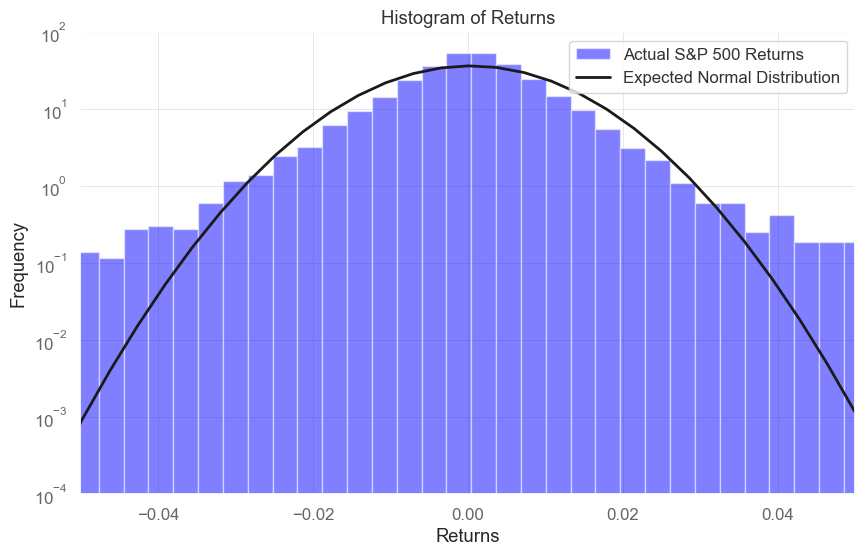

In [58]:
# plot the spx returns distribution overlaid over the an expected normal distribution
returns = spx.pct_change().dropna()

plt.hist(returns, bins=100, density=True, color='blue', alpha=0.5, label='Actual S&P 500 Returns')

mu, std = norm.fit(returns)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Expected Normal Distribution')

plt.legend(loc='upper right')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.title('Histogram of Returns')
# limit x axis
plt.xlim(-0.05, 0.05)
# change to log y
plt.yscale('log')
plt.ylim(1e-4, 1e2)
plt.show()


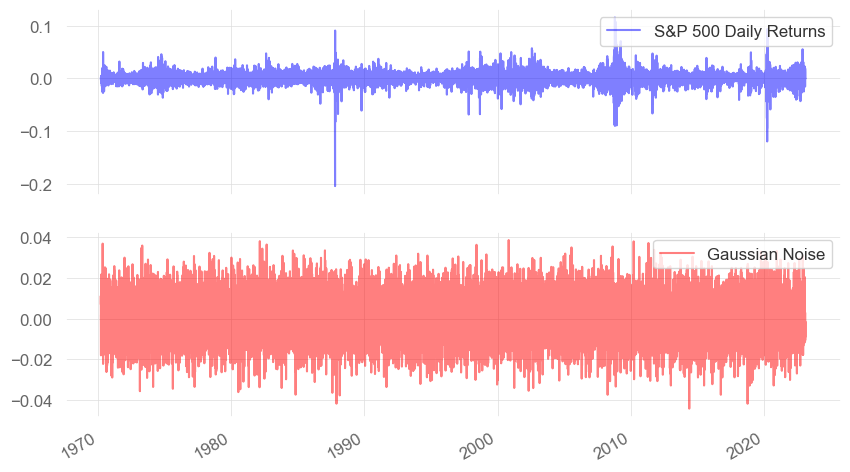

In [59]:
noise = np.random.normal(mu, std, len(spx))
noise = pd.Series(noise, index=spx.index)

# do the same chart as above but in two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
spx.pct_change().plot(color='blue', alpha=0.5, label='S&P 500 Daily Returns', ax=ax1)
noise.plot(color='red', alpha=0.5, label='Gaussian Noise', ax=ax2)
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
plt.show()



In [60]:
vocab = pd.qcut(spx.pct_change(), 10).value_counts()
vocab = vocab.index.sort_values().to_list()
vocab = {v:i for i,v in enumerate(vocab)}
vocab_encode = {str(i):v for i,v in enumerate(vocab)}
vocab_decode = {v:str(i) for i,v in vocab_encode.items()}

vocab_decode


{Interval(-0.206, -0.0111, closed='right'): '0',
 Interval(-0.0111, -0.00629, closed='right'): '1',
 Interval(-0.00629, -0.00327, closed='right'): '2',
 Interval(-0.00327, -0.00127, closed='right'): '3',
 Interval(-0.00127, 0.000471, closed='right'): '4',
 Interval(0.000471, 0.00224, closed='right'): '5',
 Interval(0.00224, 0.00435, closed='right'): '6',
 Interval(0.00435, 0.00706, closed='right'): '7',
 Interval(0.00706, 0.0116, closed='right'): '8',
 Interval(0.0116, 0.116, closed='right'): '9'}

In [92]:
def encode_series(series, vocab_encode):
    keys = []
    for value in series:
        for key, interval in vocab_encode.items():
            if value in interval:
                keys.append(key)
                break
    return keys

def decode_keys(keys, vocab_decode):
    typical_ = spx.pct_change()
    intervals = []
    for key in keys:
        interval = vocab_decode.get(key)
        if interval:            
            typical = typical_[typical_.between(interval.left, interval.right)]
            typical = typical.sample(1).iloc[-1]
            intervals.append(typical)
        else:
            raise ValueError(f"Invalid key: {key}")
    return pd.Series(intervals)


codes = encode_series(spx.pct_change(), vocab_encode)
codes = ''.join(codes)



In [ ]:
"""
Trains a character-level language model.
"""

import os
import sys

import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader

from mingpt.model import GPT
from mingpt.trainer import Trainer
from mingpt.utils import set_seed, setup_logging, CfgNode as CN

# -----------------------------------------------------------------------------

def get_config():

    C = CN()

    # system
    C.system = CN()
    C.system.seed = 3407
    C.system.work_dir = './out/chargpt'

    # data
    C.data = CharDataset.get_default_config()

    # model
    C.model = GPT.get_default_config()
    C.model.model_type = 'gpt-nano'

    # trainer
    C.trainer = Trainer.get_default_config()
    C.trainer.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster

    return C

# -----------------------------------------------------------------------------

class CharDataset(Dataset):
    """
    Emits batches of characters
    """

    @staticmethod
    def get_default_config():
        C = CN()
        C.block_size = 128
        return C

    def __init__(self, config, data):
        self.config = config

        chars = sorted(list(set(data)))
        data_size, vocab_size = len(data), len(chars)
        print('data has %d characters, %d unique.' % (data_size, vocab_size))

        self.stoi = { ch:i for i,ch in enumerate(chars) }
        self.itos = { i:ch for i,ch in enumerate(chars) }
        self.vocab_size = vocab_size
        self.data = data

    def get_vocab_size(self):
        return self.vocab_size

    def get_block_size(self):
        return self.config.block_size

    def __len__(self):
        return len(self.data) - self.config.block_size

    def __getitem__(self, idx):
        # grab a chunk of (block_size + 1) characters from the data
        chunk = self.data[idx:idx + self.config.block_size + 1]
        # encode every character to an integer
        dix = [self.stoi[s] for s in chunk]
        # return as tensors
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long)
        return x, y

# -----------------------------------------------------------------------------

if __name__ == '__main__':

    # get default config and overrides from the command line, if any
    config = get_config()
    print(config)
    setup_logging(config)
    set_seed(config.system.seed)

    # construct the training dataset
    train_dataset = CharDataset(config.data, codes)

    # construct the model
    config.model.vocab_size = train_dataset.get_vocab_size()
    config.model.block_size = train_dataset.get_block_size()
    model = GPT(config.model)

    # construct the trainer object
    trainer = Trainer(config.trainer, model, train_dataset)

    # iteration callback
    def batch_end_callback(trainer):

        if trainer.iter_num % 50 == 0:
            print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")

        if trainer.iter_num % 500 == 0:
            # evaluate both the train and test score
            model.eval()
            with torch.no_grad():
                # sample from the model...
                context = codes[-121:]
                x = torch.tensor([train_dataset.stoi[s] for s in context], dtype=torch.long)[None,...].to(trainer.device)
                y = model.generate(x, 500, temperature=1.0, do_sample=True)[0]
                completion = ''.join([train_dataset.itos[int(i)] for i in y])
                print(completion)
            # save the latest model
            print("saving model")
            ckpt_path = os.path.join(config.system.work_dir, "model.pt")
            torch.save(model.state_dict(), ckpt_path)
            # revert model to training mode
            model.train()

    trainer.set_callback('on_batch_end', batch_end_callback)

    # run the optimization
    trainer.run()


In [ ]:
d = {}

for i in range(1000):
    with torch.no_grad():
        # sample from the model...
        context = codes[-126:]
        x = torch.tensor([train_dataset.stoi[s] for s in context], dtype=torch.long)[None,...].to(trainer.device)
        y = model.generate(x, 252*10, temperature=1.0, do_sample=True)[0]
        completion = ''.join([train_dataset.itos[int(i)] for i in y])
        
    sim_rets = decode_keys(completion, vocab_encode)

    d[i] = sim_rets.iloc[-252*10:]

df = pd.DataFrame(d)


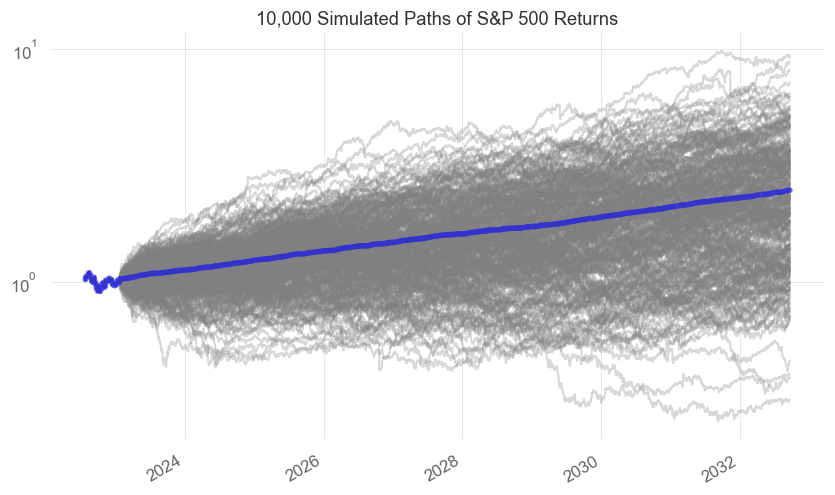

In [198]:
forecasts = {}

for c in df.columns:
    context = spx.pct_change().iloc[-126:]

    forecast_ret = pd.Series(df[c].values, index=pd.date_range(context.index[-1], periods=252*10, freq='B'))
    forecast = (pd.concat([context, forecast_ret])+1).cumprod()
    forecasts[c] = forecast

forecast_df = pd.DataFrame(forecasts)
axes = forecast_df.plot(logy=True, legend=False, alpha=0.3, color='gray')
axes.plot(forecast_df.mean(1), label='Average Path', color='blue', linewidth=4, alpha=0.6)
plt.title('10,000 Simulated Paths of S&P 500 Returns')
plt.show()


In [201]:
forecast_df.apply(qs.stats.volatility).mean(), forecast_df.apply(qs.stats.cagr).mean()


(0.18151111025494512, 0.07473533974273064)

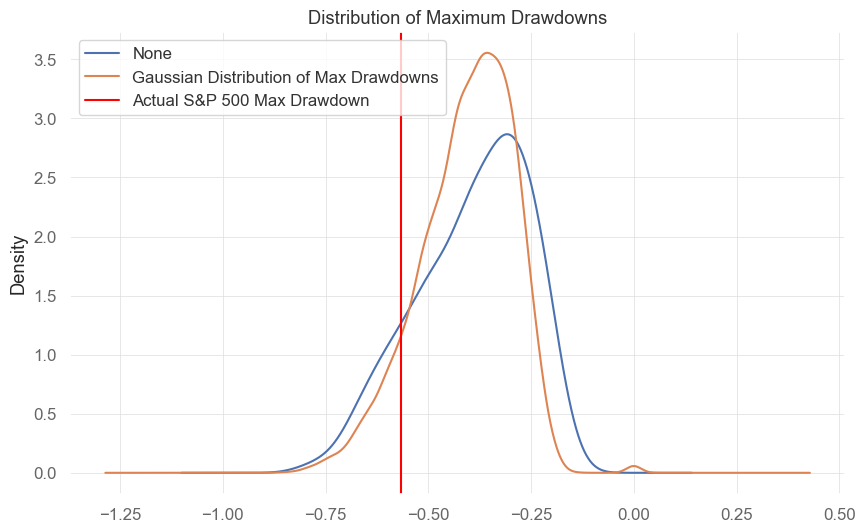

In [234]:
sim = {}
mu, std = norm.fit(returns)
for i in range(10000):
    p = np.random.normal(mu, std, 252*10)
    sim[i] = (1+p).cumprod()

gaussian_df = pd.DataFrame(sim)
gaussian_max_dd = gaussian_df.apply(qs.stats.max_drawdown)

forecast_df.apply(qs.stats.max_drawdown).plot(kind='kde')
# overlay the gaussian distribution
gaussian_max_dd.plot(kind='kde', label='Gaussian Distribution of Max Drawdowns')
plt.title('Distribution of Maximum Drawdowns')
plt.axvline(-0.567, color='red', label='Actual S&P 500 Max Drawdown')
plt.legend(loc='upper left')
plt.show()


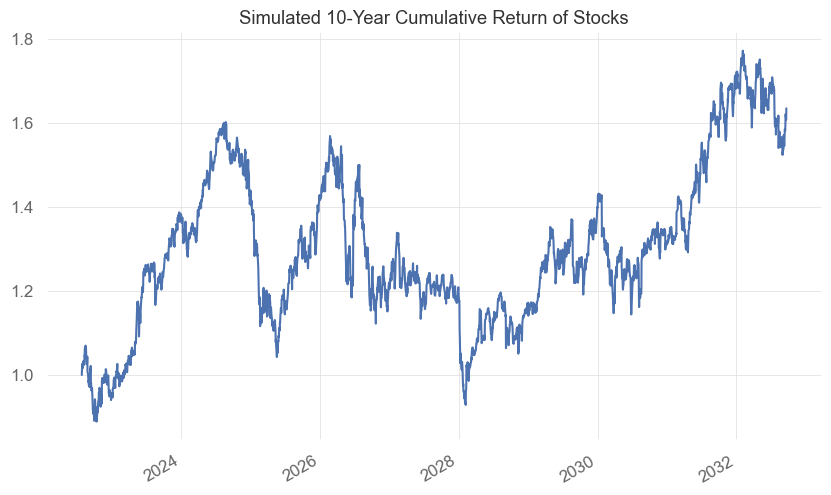

In [171]:
idx = 37
(forecast_df[idx] / forecast_df[idx].iloc[0]).plot(logy=False, title="Simulated 10-Year Cumulative Return of Stocks")
plt.show()


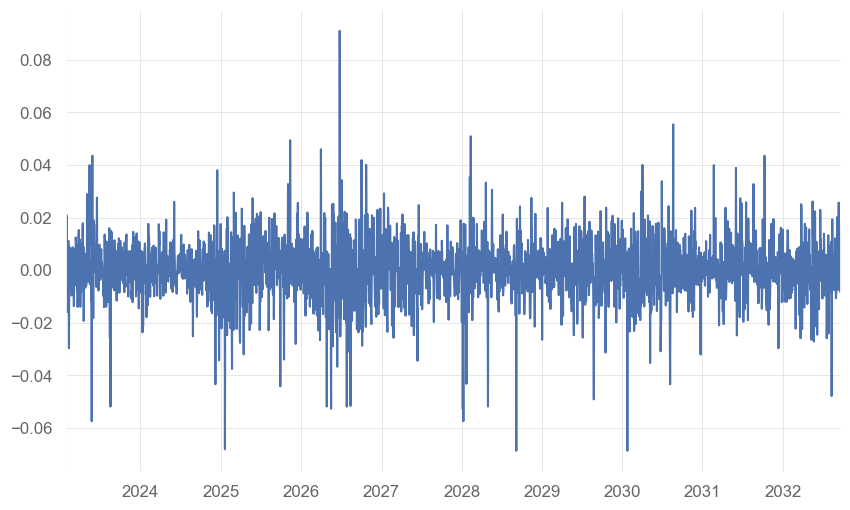

In [172]:

forecast_df.pct_change().iloc[-252*10:][idx].plot()
plt.show()


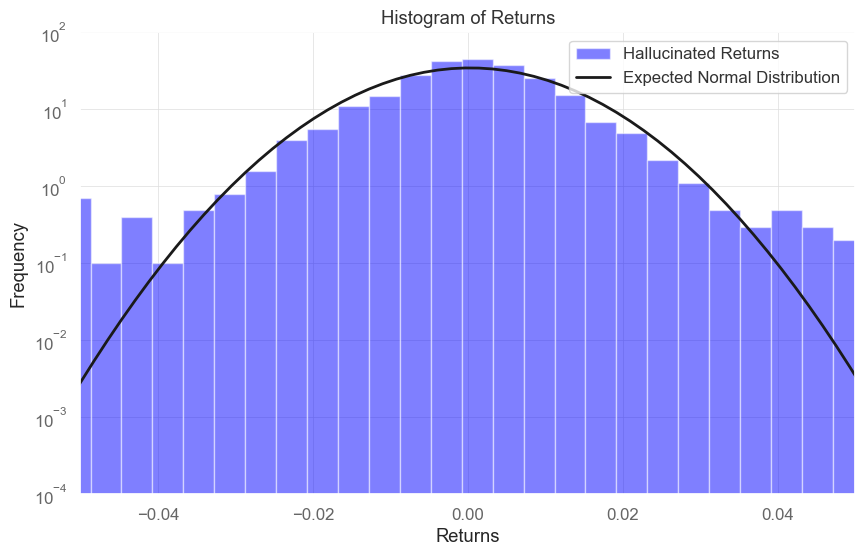

In [176]:
# plot the spx returns distribution overlaid over the an expected normal distribution
returns = forecast_df.pct_change().iloc[-252*10:][idx]

plt.hist(returns, bins=40, density=True, color='blue', alpha=0.5, label='Hallucinated Returns')

mu, std = norm.fit(returns)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Expected Normal Distribution')

plt.legend(loc='upper right')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.title('Histogram of Returns')
# limit x axis
plt.xlim(-0.05, 0.05)
# change to log y
plt.yscale('log')
plt.ylim(1e-4, 1e2)
plt.show()


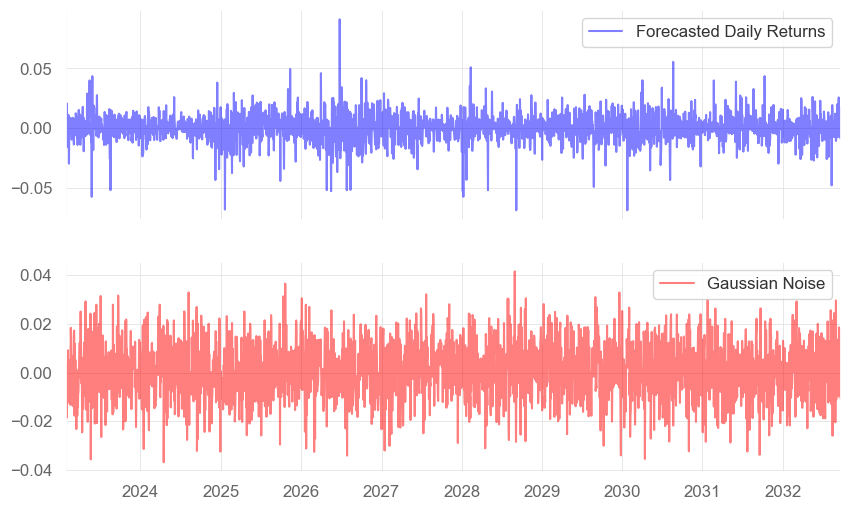

In [180]:
noise = np.random.normal(mu, std, len(returns))
noise = pd.Series(noise, index=returns.index)

# do the same chart as above but in two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
returns.plot(color='blue', alpha=0.5, label='Forecasted Daily Returns', ax=ax1)
noise.plot(color='red', alpha=0.5, label='Gaussian Noise', ax=ax2)
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
plt.show()



<AxesSubplot:>

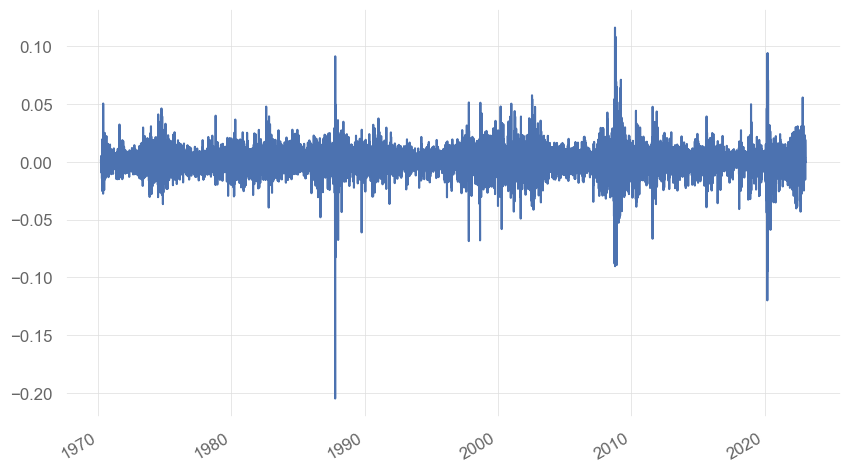

In [102]:
spx.pct_change().plot()